In [1]:
%load_ext autoreload
%autoreload 2

# Self-Driving Car Engineer Nanodegree

## Project: **Advanced Lane Finding on the Road** 
***

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


Above that, I might use tools below that I used previous project. I put it here to remember for my own sake.
* Color selection
* Region of interest selection
* Grayscaling
* Gaussian smoothing
* Canny Edge Detection and Hough Transform


## Goal Image
***
Now I got overview of this project, let's take a look training / expected output image first.


<figure>
 <img src="test_images/straight_lines1.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Original input image should look something like this (above) </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/example_output.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Goal is to implement pipeline to get output like this </p> 
 </figcaption>
</figure>



## Programming time!(≧∇≦)b
***

### Import Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

%matplotlib inline

### Camera Calibration

First, I'll compute the camera calibration using chessboard images. I use given images, and extract object and image points. 

In [3]:
from helper import get_obj_image_points

# Get given chessboard images path list
cal_images = glob.glob('./camera_cal/calibration*.jpg')
fx = 9
fy = 6

objpoints, imgpoints = get_obj_image_points(fx, fy, cal_images)

Then I got object points and imagepoints, I calibrate, calculate distortion coefficients, and test undistortion on an image.

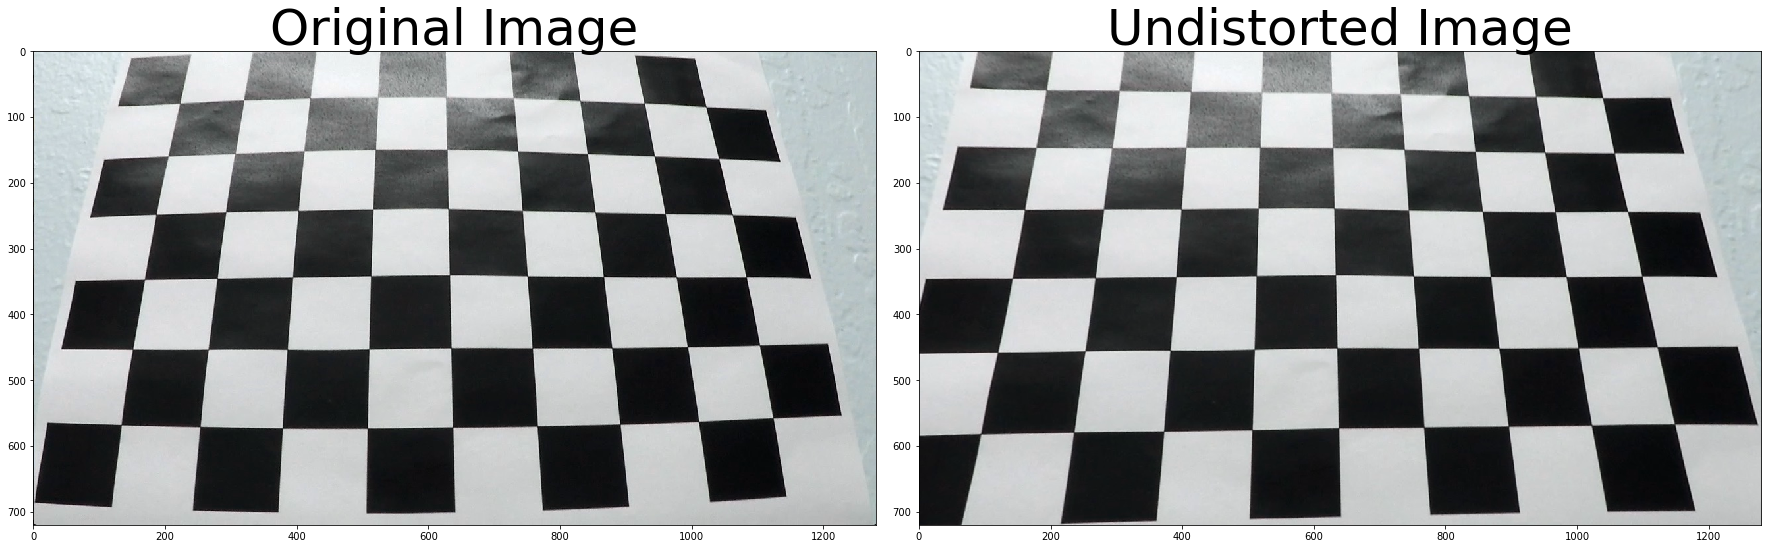

In [4]:
from helper import calibrate_camera, undistort_image, plot_two_image

# Test undistortion
cal_img_3 = cv2.imread('camera_cal/calibration3.jpg')

ret, mtx, dist, _, _ = calibrate_camera(objpoints, imgpoints, cal_img_3.shape[:-1])
undist = undistort_image(cal_img_3, mtx, dist)

plot_two_image(cal_img_3, undist, 'Original Image', 'Undistorted Image')


In [5]:
# from helper import save_rgb_image
# save_rgb_image(cal_img_3, 'original_chess')
# save_rgb_image(undist, 'undist_chess')

### Distortion correction
Output above seems close to expected result, I try it out to road test images as well.

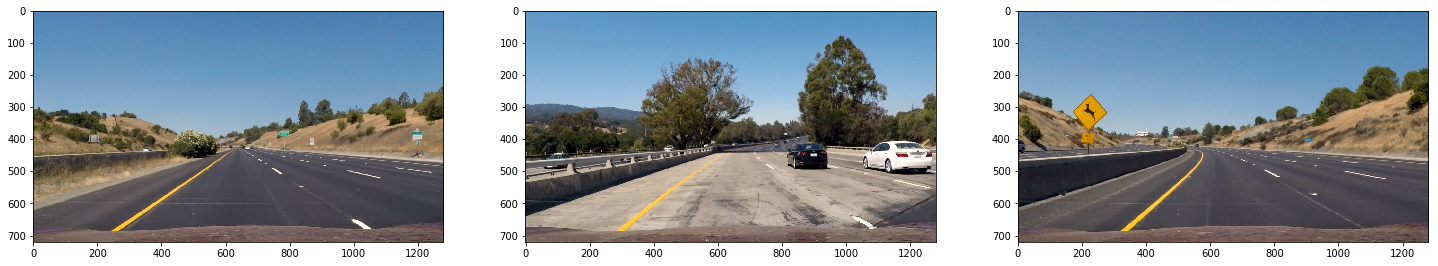

In [6]:
from helper import plot_images
STRAIGHT_LINE_IMG = cv2.imread('test_images/straight_lines1.jpg')
RIGHT_CURVED_IMG = cv2.imread('test_images/test1.jpg')
LEFT_CURVED_IMG = cv2.imread('test_images/test2.jpg')
TEST_3_IMG = [STRAIGHT_LINE_IMG, RIGHT_CURVED_IMG, LEFT_CURVED_IMG]
# Convert image to rgb
TEST_3_IMG = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in TEST_3_IMG]

plot_images(TEST_3_IMG)

In [7]:
# save_rgb_image(TEST_3_IMG[0], 'test1')
# save_rgb_image(TEST_3_IMG[1], 'test2')
# save_rgb_image(TEST_3_IMG[2], 'test3')

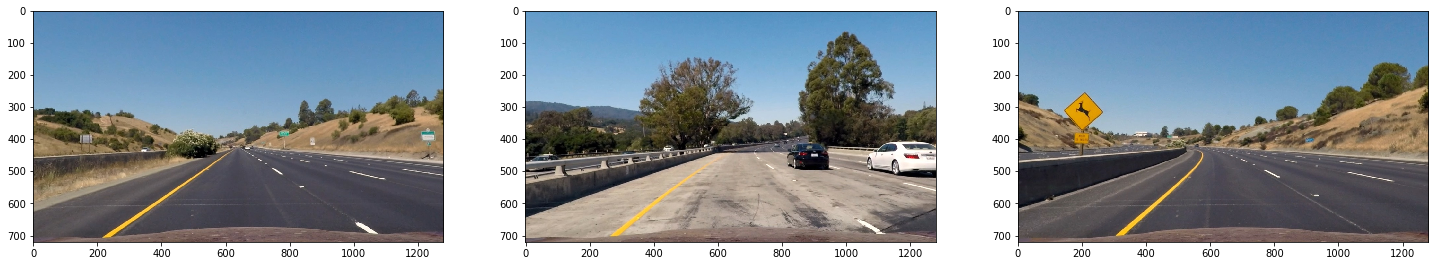

In [8]:
from helper import undistort_image
# Test undistortion on an image
undist_images = [undistort_image(img, mtx, dist) for img in TEST_3_IMG]

plot_images(undist_images)

In [9]:
# save_rgb_image(undist_images[0], 'undist_test1')
# save_rgb_image(undist_images[1], 'undist_test2')
# save_rgb_image(undist_images[2], 'undist_test3')

I correct distortion using `cal_undistort` above, and save these output to `./output_images` folder.

### Color/gradient threshold
I test each threshold using `mag_threshold` and `dir_threshold` 

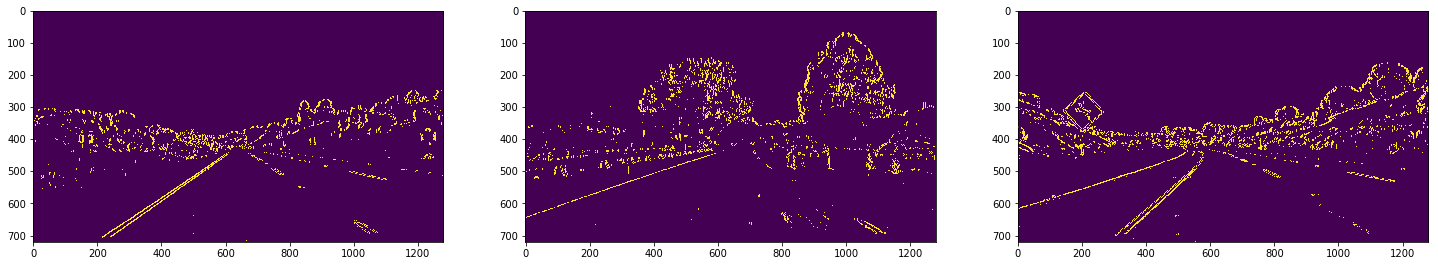

In [10]:
from helper import gaussian_blur, mag_thresh, plot_two_image

# Test some kind of threshold image
mag_binary_images = []
for img in undist_images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = gaussian_blur(img, kernel_size=7)
    mag_binary_images.append(mag_thresh(img, sobel_kernel=15, thresh=(110/3, 110)))

plot_images(mag_binary_images)

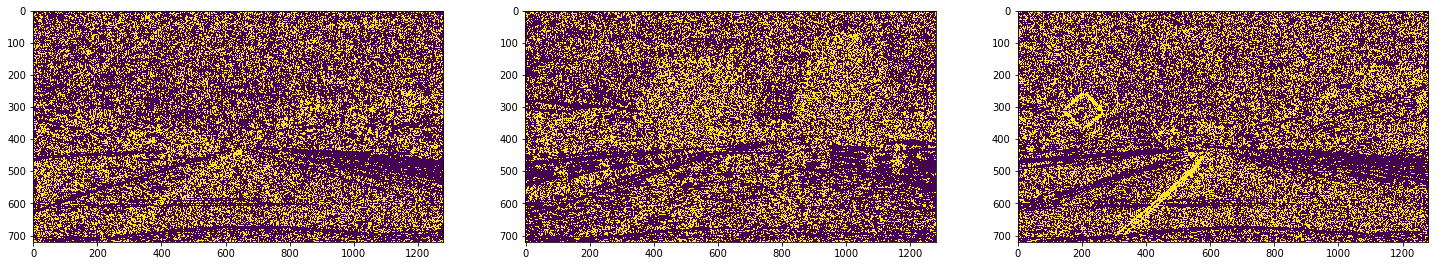

In [11]:
from helper import dir_thresh

dir_binary_images = []
for img in undist_images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = gaussian_blur(img, kernel_size=7)
    dir_binary_images.append(dir_thresh(img, sobel_kernel=15, thresh=(0.6, 1.3)))

plot_images(dir_binary_images)

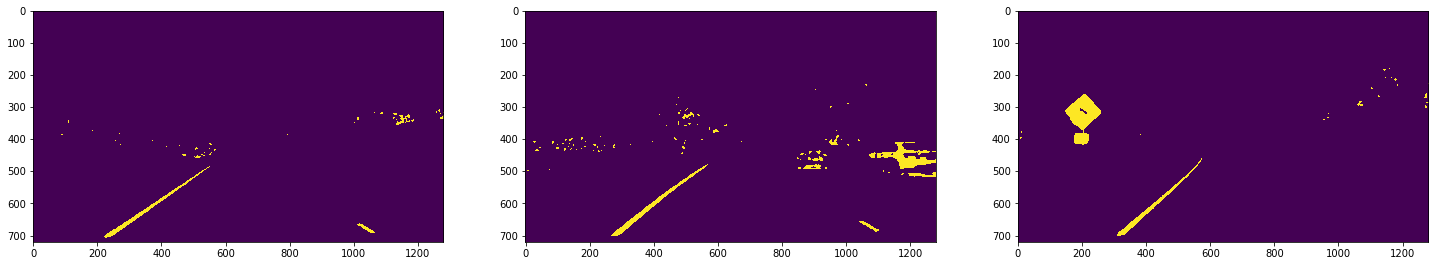

In [12]:
from helper import col_thresh

col_binary_images = []
for img in undist_images:
    col_binary_images.append(col_thresh(img, thresh=(150, 255)))

plot_images(col_binary_images)

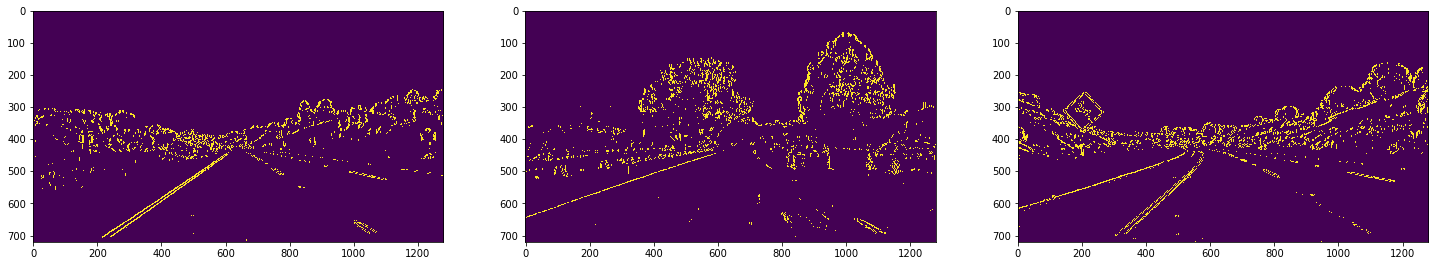

In [13]:
from helper import sobel_x_thresh

sobel_x_binary_images = []
for img in undist_images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = gaussian_blur(img, kernel_size=7)
    sobel_x_binary_images.append(sobel_x_thresh(img, thresh=(35, 100)))

plot_images(sobel_x_binary_images)

### Perspective transform

In [14]:
from helper import get_src_points, get_dst_points

# All test images are the same shape
img_size = (RIGHT_CURVED_IMG.shape[1], RIGHT_CURVED_IMG.shape[0])

src = get_src_points(img_size)
dst = get_dst_points(img_size)

To test if I get warped image correctly, I see the each one. If I see the image in this order, straight, right, and left, `warpe_image` works as expected

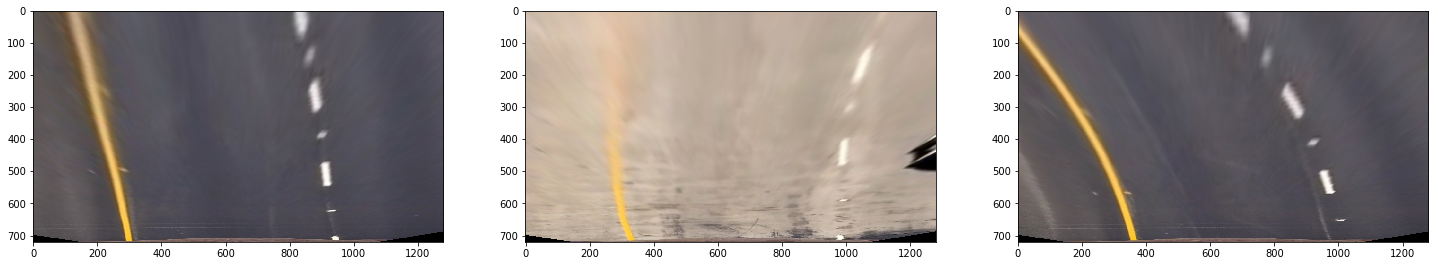

In [15]:
from helper import warpe_image

warped_images = [warpe_image(img, src, dst) for img in undist_images]
plot_images(warped_images)


In [16]:
# save_rgb_image(warped_images[0], 'warped_test1')
# save_rgb_image(warped_images[1], 'warped_test2')
# save_rgb_image(warped_images[2], 'warped_test3')

Seems correct at first glance, but let's make sure if it is so, by drawing red line

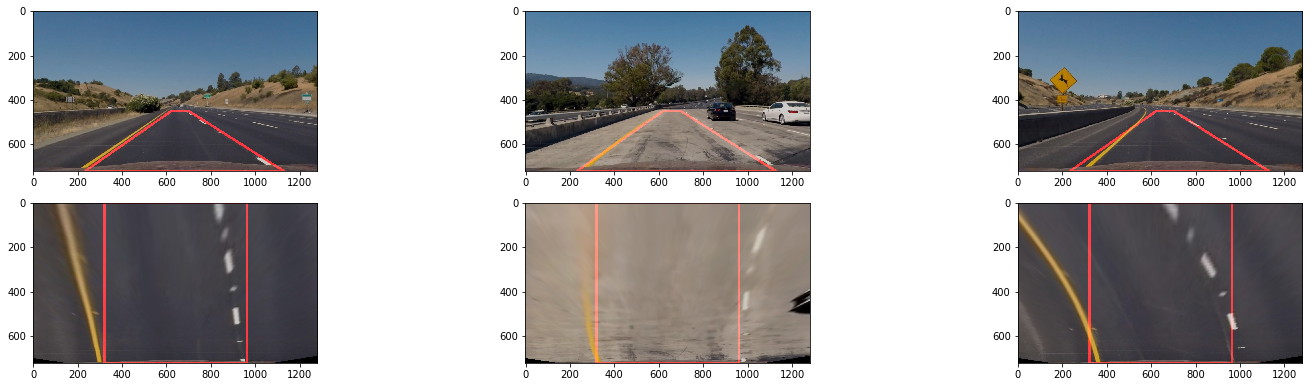

In [17]:
red_lined_images = []
# Draw red lines in undistorted test image
for img in undist_images:
    empty_img = np.copy(img) * 0
    # Draw line, going throuch src points, on empty img
    cv2.polylines(empty_img, [src.astype(np.int64)], True, (255, 0, 0), thickness=10)

    # Put line image and undist image together
    output_img = cv2.addWeighted(img, 0.8, empty_img, 1, 0)
    red_lined_images.append(output_img)

# Draw red lines in undistorted warped image
for img in warped_images:
    empty_img = np.copy(img) * 0
    # Draw line, going through dst points
    cv2.polylines(empty_img, [dst.astype(np.int64)], True, (255, 0, 0), thickness=10)

    output_img = cv2.addWeighted(img, 0.8, empty_img, 1, 0)
    red_lined_images.append(output_img)

plot_images(red_lined_images)

In [18]:
# save_rgb_image(red_lined_images[0], 'red_lined0')
# save_rgb_image(red_lined_images[1], 'red_lined1')
# save_rgb_image(red_lined_images[2], 'red_lined2')
# save_rgb_image(red_lined_images[3], 'red_lined3')
# save_rgb_image(red_lined_images[4], 'red_lined4')
# save_rgb_image(red_lined_images[5], 'red_lined5')

Ok, now I'm gonna test its perspective transformation by applying it to threshold binary images.

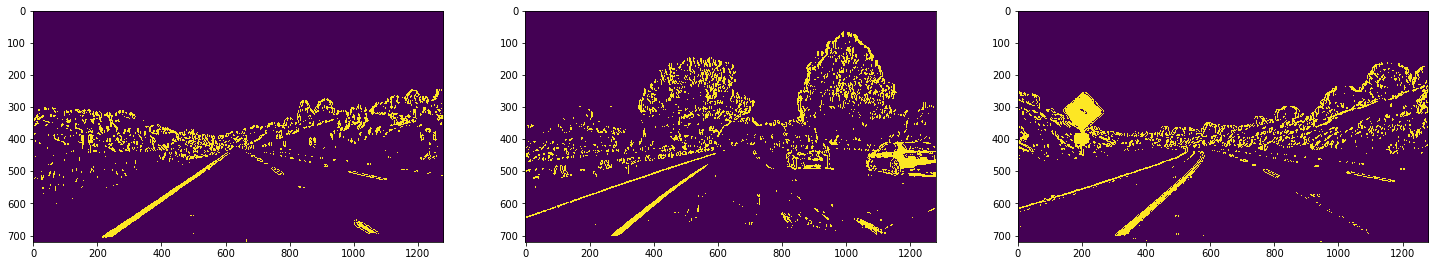

In [19]:
binary_images = []
for img in undist_images:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = gaussian_blur(gray_img, kernel_size=11)

    # Get magnitude threshold binary
    mag_binary = mag_thresh(gray_img, sobel_kernel=15, thresh=(110/3, 110))
    # Get direction of the gradient binary
    dir_binary = dir_thresh(gray_img, sobel_kernel=15, thresh=(0.7, 1.3))
    # Get sobel binary on x axis
    sobel_x_binary = sobel_x_thresh(gray_img, thresh=(30, 100))
    # Get color binary
    col_binary = col_thresh(img, thresh=(150, 255))

    # Combine all above binary, magnitude, direction of the gradient, color, and sobel x
    binary_img = np.zeros_like(col_binary)
    binary_img[(col_binary == 1) |
               (sobel_x_binary == 1) |
               (mag_binary == 1) & (dir_binary == 1)] = 1

    binary_images.append(binary_img)

plot_images(binary_images)

In [20]:
# save_rgb_image(binary_images[0], 'binary_images0')
# save_rgb_image(binary_images[1], 'binary_images1')
# save_rgb_image(binary_images[2], 'binary_images2')

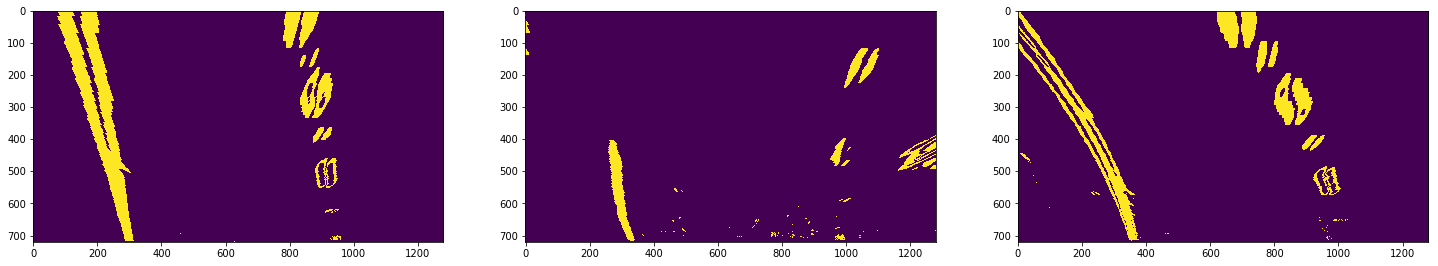

In [21]:
# Get warped image from binary one
warped_binary_images = [warpe_image(img, src, dst) for img in binary_images]

plot_images(warped_binary_images)

In [22]:
# save_rgb_image(warped_binary_images[0], 'binary_warped_images0')
# save_rgb_image(warped_binary_images[1], 'binary_warped_images1')
# save_rgb_image(warped_binary_images[2], 'binary_warped_images2')

### Detect lane lines

- Loop through each window in nwindows
- Find the boundaries of our current window. This is based on a combination of the current window's starting point (leftx_current and rightx_current), as well as the margin you set in the hyperparameters.
- Use cv2.rectangle to draw these window boundaries onto our visualization image out_img. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.
- Knwo the boundaries of our window, find out which activated pixels from nonzeroy and nonzerox above actually fall into the window.
- Append these to our lists left_lane_inds and right_lane_inds.
- If the number of pixels you found in Step 4 are greater than your hyperparameter minpix, re-center our window (i.e. leftx_current or rightx_current) based on the mean position of these pixels.

In [23]:
from helper import get_src_points, get_dst_points

img_size = undist_images[0].shape[:-1]
src = get_src_points(img_size)
dst = get_dst_points(img_size)
src, dst


(array([[  340.,   730.],
        [  140.,  1280.],
        [  660.,  1280.],
        [  420.,   730.]], dtype=float32), array([[  180.,     0.],
        [  180.,  1280.],
        [  540.,  1280.],
        [  540.,     0.]], dtype=float32))

In [24]:
# from helper import find_lane_pixels, fit_polynomial, reverse_colored_warp_image

# test_img_i = 1
# warp_binary_img = warped_binary_images[test_img_i]

# left_x, left_y, right_x, right_y = find_lane_pixels(warp_binary_img)

# # # Extract polynomial from warped binary image
# ploty, left_fit_x, right_fit_x = fit_polynomial(warp_binary_img, left_x, left_y, right_x, right_y)

# # Get reverse warped image with colored lane area
# new_warp = reverse_colored_warp_image(warp_binary_img, left_fit_x, right_fit_x, ploty, src, dst)

# # Put undist image and new_warp together
# output = cv2.addWeighted(undist_images[test_img_i], 1, new_warp, 0.3, 0)

# plt.imshow(warp_binary_img)

### Pipeline for image

In [27]:
from helper import grayscale_image, gaussian_blur, undistort_image, mag_thresh, dir_thresh, col_thresh, sobel_x_thresh, warpe_image, fit_polynomial, find_lane_pixels, calibrate_camera, reverse_colored_warp_image, measure_curvature, measure_pos_from_center, draw_two_text


def image_pipeline(rgb_img):
    """
    Input: RGB image
    Output: Edge with colored track image
    """
    img_size = (rgb_img.shape[1], rgb_img.shape[0])

    # Make rgb image undistorted
    ret, mtx, dist, _, _ = calibrate_camera(objpoints, imgpoints, img_size)
    rgb_img = undistort_image(rgb_img, mtx, dist)

    # Get grayscaled image
    gray_img = grayscale_image(rgb_img)
    # Apply gaussian blur to gray image
    gray_img = gaussian_blur(gray_img, kernel_size=11)


    # Get magnitude threshold binary
    mag_binary = mag_thresh(gray_img, sobel_kernel=15, thresh=(110/3, 110))
    # Get direction of the gradient binary
    dir_binary = dir_thresh(gray_img, sobel_kernel=15, thresh=(0.7, 1.3))
    # Get sobel binary on x axis
    sobel_x_binary = sobel_x_thresh(gray_img, thresh=(30, 100))
    # Get color binary
    col_binary = col_thresh(rgb_img, thresh=(150, 255))

    # Combine all above binary, magnitude, direction of the gradient, color, and sobel x
    binary_img = np.zeros_like(col_binary)
    binary_img[(col_binary == 1) |
               (sobel_x_binary == 1) |
               (mag_binary == 1) & (dir_binary == 1)] = 1


    # Get warped binary image
    src = get_src_points(img_size)
    dst = get_dst_points(img_size)
    warped_binary = warpe_image(binary_img, src, dst)

    # Extract each pixels on lane
    left_x, left_y, right_x, right_y = find_lane_pixels(warped_binary)


    # Extract polynomial from warped binary image
    ploty, left_fit_x, right_fit_x, left_fit, right_fit = fit_polynomial(warped_binary, left_x, left_y, right_x, right_y)


    # Calculate position from the center
    position = measure_pos_from_center(img_size, left_x, right_x)
    # Calculate curvature
    curvature = measure_curvature(ploty, left_x, left_y, right_x, right_y)

    # Get reverse warped image with colored lane area
    new_warp = reverse_colored_warp_image(warped_binary, left_fit_x, right_fit_x, ploty, src, dst)

    output_img = cv2.addWeighted(rgb_img, 1, new_warp, 0.3, 0)
    # Draw position and curvature
    draw_two_text(output_img, position, curvature)

    return output_img


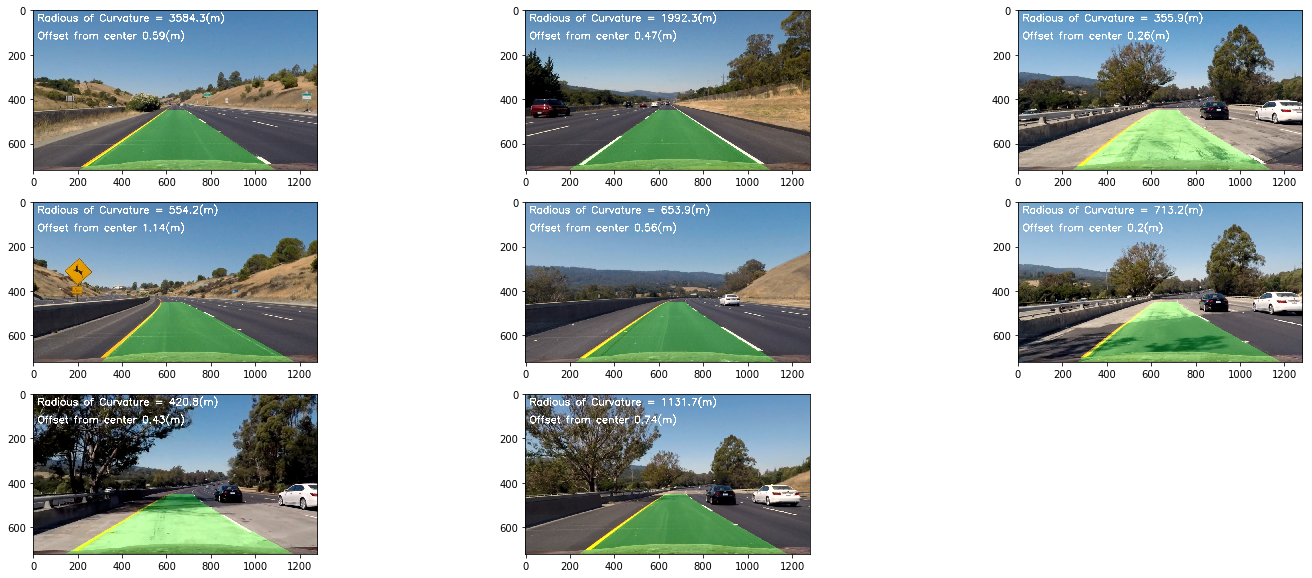

In [29]:
# test_img = cv2.imread('test_images/test1.jpg')
# test_img = test_img[:, :, [2, 1, 0]]
# test_img = image_pipeline(test_img)
# plt.imshow(test_img)

test_images = []
for img in glob.glob('./test_images/*.jpg'):
    img = cv2.imread(img)
    img = img[:, :, [2, 1, 0]]
    test_images.append(image_pipeline(img))

plot_images(test_images)

In [32]:
# from helper import save_rgb_image
# save_rgb_image(test_images[0], 'test_output0')
# save_rgb_image(test_images[1], 'test_output1')
# save_rgb_image(test_images[2], 'test_output2')
# save_rgb_image(test_images[3], 'test_output3')
# save_rgb_image(test_images[4], 'test_output4')
# save_rgb_image(test_images[5], 'test_output5')
# save_rgb_image(test_images[6], 'test_output6')
# save_rgb_image(test_images[7], 'test_output7')

### Pipeline for video

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0761856/28549024 bytes (2.71548288/28549024 bytes (5.4%2531328/28549024 bytes (8.9%3301376/28549024 bytes (11.64300800/28549024 bytes (15.15201920/28549024 bytes (18.26201344/28549024 bytes (21.77053312/28549024 bytes (24.77806976/28549024 bytes (27.38675328/28549024 bytes (30.49543680/28549024 bytes (33.410395648/28549024 bytes (36.4%11411456/28549024 bytes (40.0%12197888/28549024 bytes (42.7%13033472/28549024 bytes (45.7%13672448/28549024 bytes (47.9%14540800/28549024 bytes (50.9%15245312/28549024 bytes (53.4%16080896/28549024 bytes (56.3%16932864/28549024 bytes (59.3%17850368/28549024 bytes (62.5%18767872/28549024 bytes (65.7%19603456/28549024 bytes (68.7%20471808/28549024 bytes (71.7%21372928/28549024 bytes (74.9%22339584/28549024 bytes (78.2%23257088/28549024 byt

In [34]:
from helper import search_around_poly, find_lane_pixels_by_line

def video_pipeline(rgb_img):
    """
    Input: RGB image
    Output: Edge with colored track image
    """
    if video_image.existed is False:
        video_image.existed = True
        video_image.size = (rgb_img.shape[1], rgb_img.shape[0])
        _, mtx, dist, _, _ = calibrate_camera(objpoints, imgpoints, video_image.size)
        video_image.mtx = mtx
        video_image.dist = dist
        video_image.src = get_src_points(video_image.size)
        video_image.dst = get_dst_points(video_image.size)
    
    # Make rgb image undistorted
    rgb_img = undistort_image(rgb_img, video_image.mtx, video_image.dist)

    # Get grayscaled image
    gray_img = grayscale_image(rgb_img)
    # Apply gaussian blur to gray image
    gray_img = gaussian_blur(gray_img, kernel_size=11)


    # Get magnitude threshold binary
    mag_binary = mag_thresh(gray_img, sobel_kernel=15, thresh=(110/3, 110))
    # Get direction of the gradient binary
    dir_binary = dir_thresh(gray_img, sobel_kernel=15, thresh=(0.7, 1.3))
    # Get sobel binary on x axis
    sobel_x_binary = sobel_x_thresh(gray_img, thresh=(30, 100))
    # Get color binary
    col_binary = col_thresh(rgb_img, thresh=(140, 255))

    # Combine all above binary, magnitude, direction of the gradient, color, and sobel x
    binary_img = np.zeros_like(col_binary)
    binary_img[(col_binary == 1) |
               (sobel_x_binary == 1) |
               (mag_binary == 1) & (dir_binary == 1)] = 1


    # Get warped binary image
    warped_binary = warpe_image(binary_img, video_image.src, video_image.dst)

    # Extract line pixels, using previous found line if it exists
    left_x, left_y, right_x, right_y = find_lane_pixels_by_line(warped_binary, line)

    # Extract polynomial from warped binary image
    ploty, left_fit_x, right_fit_x, left_fit, right_fit = fit_polynomial(warped_binary, left_x, left_y, right_x, right_y)

    # Set line if it exits
    if (len(left_x) > 0) & (len(right_x) > 0):
        line.is_detected = True
        line.recent_left_fit = left_fit
        line.recent_right_fit = right_fit
        line.recent_position = measure_pos_from_center(video_image.size, left_x, right_x)
        line.recent_curvature = measure_curvature(ploty, left_x, left_y, right_x, right_y)
    else:
        line.is_detected = False

    # Get reverse warped image with colored lane area
    new_warp = reverse_colored_warp_image(warped_binary, left_fit_x, right_fit_x, ploty, video_image.src, video_image.dst)

    output_img = cv2.addWeighted(rgb_img, 1, new_warp, 0.3, 0)
    # Draw position and curvature
    draw_two_text(output_img, line.recent_position, line.recent_curvature)

    return output_img


In [35]:
class Video_Image():
    def __init__(self):
        self.existed = False
        self.size = None
        self.mtx = None
        self.dist = None
        self.src = None
        self.dst = None

class Line():
    def __init__(self):
        self.is_detected = False
        self.recent_left_fit = [0, 0, 0]
        self.recent_right_fit = [0, 0, 0]
        self.recent_position = 0.0
        self.recent_curvature = 0.0


video_image = Video_Image()
line = Line()

output = 'project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(video_pipeline) #NOTE: this function expects RGB color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4
100%|█████████▉| 1260/1261 [04:58<00:00,  4.74it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 7min 9s, sys: 10.1 s, total: 7min 19s
Wall time: 5min
